## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_agent = pd.read_csv('assessment_data/AGENT.csv')
df_main = pd.read_csv('assessment_data/MAIN.csv')
df_b = pd.read_csv('assessment_data/B.csv')
df_c = pd.read_csv('assessment_data/C.csv')  
df_d = pd.read_csv('assessment_data/D.csv')
df_e = pd.read_csv('assessment_data/E.csv')

Since we are only interested in  the Inforceagents under the agency distribution channel. We will filter the agent data first

In [3]:
print(len(df_agent))
df_agent = df_agent[(df_agent['AGT_CHANNEL'] == 'AGENCY') & (df_agent['AGT_STATUS'] == 'INFORCE')]
print(len(df_agent))
agent_code_list = df_agent['AGT_CD'].unique().tolist()

4812
3231


In [4]:
#filter out the agents that are inforce and have channel as AGENCY
print(len(df_main))
df_main = df_main[df_main['AGT_CD'].isin(agent_code_list)]
print(len(df_main))

598269
495854


Here I Assume LAT == LA Takaful , then we replace the value for joining the table to main

In [5]:
df_b['CHAR_VALUE2'] = np.where(df_b['CHAR_VALUE2'] == 'LA TAKAFUL','LAT', df_b['CHAR_VALUE2'])
df_d['CHAR_VALUE2'] = np.where(df_d['CHAR_VALUE2'] == 'LA TAKAFUL','LAT', df_d['CHAR_VALUE2'])

In [6]:
#rename the column to left join
df_main = df_main.rename(columns = {'PRODUCT_CD':'PURPOSE_CODE'})
df_main_b = pd.merge(df_main, df_b[['CHAR_VALUE','CHAR_VALUE2','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE','S_BASE'], right_on=['PURPOSE_CODE','CHAR_VALUE2'])
df_main_b = df_main_b.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_B',
                                        'CHAR_VALUE2':'CHAR_VALUE2_B'})
#take the one is null
df_main_c = pd.merge(df_main_b, df_c[['CHAR_VALUE','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE'], right_on=['PURPOSE_CODE'])
df_main_c = df_main_c.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_C'})
df_main_d = pd.merge(df_main_c, df_d[['CHAR_VALUE','CHAR_VALUE2','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE','S_BASE'], right_on=['PURPOSE_CODE','CHAR_VALUE2'])
df_main_d = df_main_d.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_D',
                                        'CHAR_VALUE2':'CHAR_VALUE2_D'})
df_main_e = pd.merge(df_main_d, df_e[['CHAR_VALUE','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE'], right_on=['PURPOSE_CODE'])
df_main_e = df_main_e.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_E'})

In [7]:
df = df_main_e

In [8]:
#Get the main need from the main_need sql logic
df['MAIN_NEED'] = np.where(df['S_BASE'] == 'POLA', 'Accident',
                                np.where(df['CHAR_VALUE_D'].notna(), df['CHAR_VALUE_D'].str.strip(), #D
                                         np.where(df['CHAR_VALUE_E'].notna(), df['CHAR_VALUE_E'].str.strip(), #E
                                                  np.where((df['CHAR_VALUE_B'].notna()) & (df['CHAR_VALUE_B']!='Medical'), df['CHAR_VALUE_B'].str.strip(), #B
                                                           np.where((df['CHAR_VALUE_B'].notna()) & (df['CHAR_VALUE_B']=='Medical'), 'Other Medical', #B
                                                                    np.where((df['CHAR_VALUE_C'].notna()) & (df['CHAR_VALUE_C']!='Medical'), df['CHAR_VALUE_C'].str.strip(), #C
                                                                             np.where((df['CHAR_VALUE_C'].notna()) & (df['CHAR_VALUE_C']=='Medical'), 'Other Medical', None))))))) #C

In [11]:
#Fill PROD_CAT based on the product_category sql logic
df['PROD_CAT'] = np.where(df['PROD_CAT'].notna(),
                               df['PROD_CAT'], 
                               np.where((df['PROD_SUBCAT_IND_1'] == 1) & ((df['PROD_SUBCAT_IND_2'] == 1) | df['MAIN_NEED'].isin(['Medical','Other Medical','Critical Illness'])),
                                        'Cat 2',
                                        'Cat 3'))
df['PROD_CAT'].value_counts()

PROD_CAT
Cat 3    360331
Cat 2    123756
Cat 1     11767
Name: count, dtype: int64

In [19]:
df = df.drop(columns = ['CHAR_VALUE_B',
                                  'CHAR_VALUE_C',
                                  'CHAR_VALUE_D',
                                  'CHAR_VALUE_E',
                                  'CHAR_VALUE2_B',
                                  'CHAR_VALUE2_D'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495854 entries, 0 to 495853
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   POLICY_NO          495854 non-null  int64  
 1   AGT_CD             495854 non-null  int64  
 2   S_BASE             495854 non-null  object 
 3   RIDER_CD           479533 non-null  float64
 4   COVERAGE_TYPE_IND  495854 non-null  object 
 5   INS_UNIQUE_ID      495854 non-null  object 
 6   PURCHASE_DT        495854 non-null  object 
 7   PROD_CAT           495854 non-null  object 
 8   PURPOSE_CODE       495854 non-null  object 
 9   ANP_RIDER          495854 non-null  float64
 10  VIT_MBR_IND        495854 non-null  int64  
 11  PROD_SUBCAT_IND_1  495854 non-null  int64  
 12  PROD_SUBCAT_IND_2  495854 non-null  int64  
 13  MAIN_NEED          495854 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 53.0+ MB


## EDA

Questions To be Asked Regarding Data

1. Does All Rider will have the same portfolio with the basic policy.
2. Does Purchase Date of the same policy are the same or it can be different (rider for other date)
3. What does ANP meaning
4. Does Every Agent has their own specific Portfolio or they can sell any of it
5. Does ANP only for certain_product
6. Distribution of date purchase of each agent

In [20]:
df['POLICY_NO'].nunique()

125059

In [53]:
#Get the overall timeline of the data
print(df['PURCHASE_DT'].min(), df['PURCHASE_DT'].max())

2019-01-01 2030-07-31


There are error in the data as it shows year of 2030

In [55]:
#Lets check if there are policy has different date with the basic policy
policy_date = df.groupby(['POLICY_NO']).agg({'PURCHASE_DT' : 'unique'})
multiple_datee = policy_date[policy_date['PURCHASE_DT'].apply(len) > 1]
print(multiple_datee)

                                    PURCHASE_DT
POLICY_NO                                      
191        [2019-06-27, 2020-08-27, 2020-06-27]
270                    [2020-07-26, 2021-02-26]
597                    [2019-06-24, 2021-02-24]
700                    [2020-02-22, 2019-11-22]
889                    [2020-05-22, 2019-11-22]
...                                         ...
516504                 [2020-05-15, 2019-05-15]
519794                 [2019-11-07, 2020-05-07]
525845                 [2020-06-30, 2019-06-30]
542538                 [2020-04-23, 2019-04-23]
555525                 [2019-07-31, 2020-07-31]

[980 rows x 1 columns]


It means Rider can be bought in a different time from the basic policy

In [66]:
df['PURCHASE_DT'] = pd.to_datetime(df['PURCHASE_DT'])
df[df['PURCHASE_DT'].dt.year >2025]

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
141557,47644,102,LA,10300.0,R,P005020208,2030-07-31,Cat 3,RGT1,0.0,0,1,0,Savers
310350,201604,1448,LA,10300.0,R,P000562216,2030-07-06,Cat 3,RGT1,0.0,1,1,0,Savers
310515,309404,1448,LA,10300.0,R,P004507014,2030-07-29,Cat 3,RGT1,0.0,1,1,0,Savers
358968,143909,1515,LA,10300.0,R,P004768393,2030-06-22,Cat 3,RGT1,0.0,1,1,0,Savers
358991,201589,1515,LA,10300.0,R,P000975859,2030-06-01,Cat 3,RGT1,0.0,1,1,0,Savers
477473,89979,3524,LA,10300.0,R,P001349387,2030-06-14,Cat 3,RGT1,0.0,1,1,0,Savers


In [69]:
df[df['PURPOSE_CODE']=='RGT1']

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
141557,47644,102,LA,10300.0,R,P005020208,2030-07-31,Cat 3,RGT1,0.0,0,1,0,Savers
310350,201604,1448,LA,10300.0,R,P000562216,2030-07-06,Cat 3,RGT1,0.0,1,1,0,Savers
310515,309404,1448,LA,10300.0,R,P004507014,2030-07-29,Cat 3,RGT1,0.0,1,1,0,Savers
358968,143909,1515,LA,10300.0,R,P004768393,2030-06-22,Cat 3,RGT1,0.0,1,1,0,Savers
358991,201589,1515,LA,10300.0,R,P000975859,2030-06-01,Cat 3,RGT1,0.0,1,1,0,Savers
477473,89979,3524,LA,10300.0,R,P001349387,2030-06-14,Cat 3,RGT1,0.0,1,1,0,Savers


The PURPOSE CODE RGT1 is where all of the policy has error in the purchase date. Since there are many possibilities whether its a has the same date as the basic policy or different we will just drop these data.

In [70]:
df = df[df['PURCHASE_DT'].dt.year <=2025]

In [72]:
print(df['PURCHASE_DT'].min(), df['PURCHASE_DT'].max())

2019-01-01 00:00:00 2025-03-10 00:00:00


S_BASE
LA      74894
LAT     33844
POLA    16321
Name: count, dtype: int64

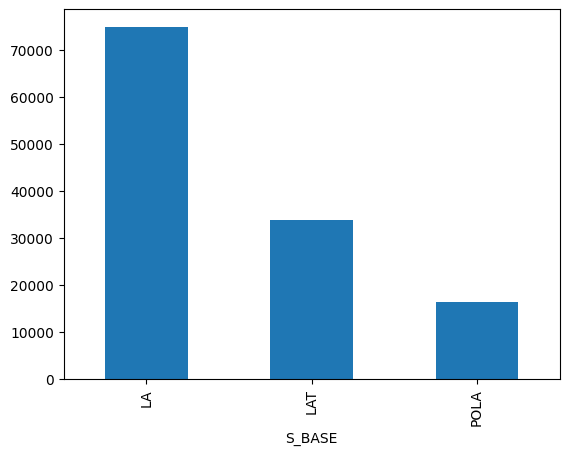

In [22]:
#get the distribution of the portfolio
df.groupby(['POLICY_NO'])['S_BASE'].first().value_counts().plot(kind='bar')
df.groupby(['POLICY_NO'])['S_BASE'].first().value_counts()

In [24]:
370809/125045

2.9654044543964173

The number are making sense , since multiple riders can be with basic policy and the Ratio are almost 3:1 For Every Basic Policy there might be 3 Rider

In [86]:
#do agent can sell different portfolio
df.groupby(['AGT_CD']).agg({'S_BASE': 'unique'})

,S_BASE
AGT_CD,
1,[LA]
2,[LA]
3,"[LA, LAT]"
4,[LA]
5,[LAT]
...,...
4806,[LA]
4807,[POLA]
4808,[LA]


yes agent can sell different product from different portfolio

In [94]:
# Does ANP is just for a certain product?
prod_code_anp = df[df['ANP_RIDER']>0]['PURPOSE_CODE'].unique().tolist()
df[(df['PURPOSE_CODE'].isin(prod_code_anp)) & (df['ANP_RIDER'] == 0)]

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
109,3,1186,LAT,10200.0,R,P004313476,2019-10-24,Cat 3,1EH7,0.0,1,1,0,Savers
272,31179,1186,LAT,10200.0,R,P010394341,2020-01-06,Cat 3,1EH8,0.0,1,1,0,Savers
300,38099,1186,LAT,10200.0,R,P001779270,2019-10-28,Cat 3,2EH8,0.0,0,1,0,Savers
414,111868,1186,LAT,10200.0,R,P010192534,2020-05-05,Cat 3,APSV,0.0,1,1,0,Savers
866,114371,3642,LA,10200.0,R,P000257359,2019-03-28,Cat 3,18ET,0.0,1,1,0,Savers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491553,190573,1756,LA,10106.0,R,P010798070,2021-01-05,Cat 3,RCC2,0.0,0,0,0,Accident
491565,243772,1756,LA,10106.0,R,P002306805,2020-11-11,Cat 3,RCC2,0.0,0,0,0,Accident
491613,399400,1756,LA,10106.0,R,P005117395,2020-12-18,Cat 3,RCC2,0.0,0,0,0,Accident
492989,256483,4755,LA,10104.0,R,P010760186,2020-12-04,Cat 3,RCC2,0.0,0,0,0,Accident


Nope the same Product code does not mean they have ANP.

PROD_CAT
Cat 1     11765
Cat 2     61438
Cat 3    101787
Name: POLICY_NO, dtype: int64

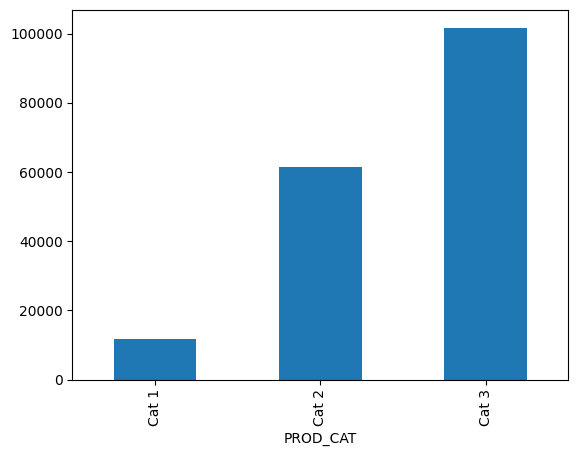

In [28]:
# Question 1
# What is the total number of policies sold by product categories?
df.groupby(['PROD_CAT'])['POLICY_NO'].nunique().plot(kind='bar')
df.groupby(['PROD_CAT'])['POLICY_NO'].nunique()

<Axes: ylabel='Frequency'>

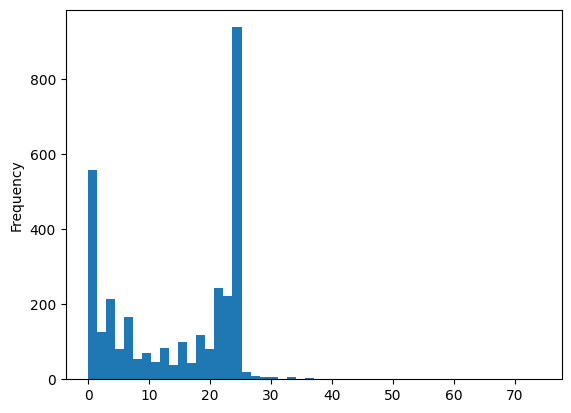

In [105]:
# Agent Distribution on Notice Served
date_df = df.groupby(['AGT_CD']).agg(
    PURCHASE_DT_MIN=('PURCHASE_DT', 'min'),
    PURCHASE_DT_MAX=('PURCHASE_DT', 'max')
)
date_df['MONTHS_DIFF'] = (
    (date_df['PURCHASE_DT_MAX'].dt.year - date_df['PURCHASE_DT_MIN'].dt.year) * 12 + 
    (date_df['PURCHASE_DT_MAX'].dt.month - date_df['PURCHASE_DT_MIN'].dt.month)
)
date_df['MONTHS_DIFF'].plot(kind='hist',bins=50)

Quite A lot of number are in the early stage and the mod is around 2 years+

<Axes: xlabel='LAST_YEAR'>

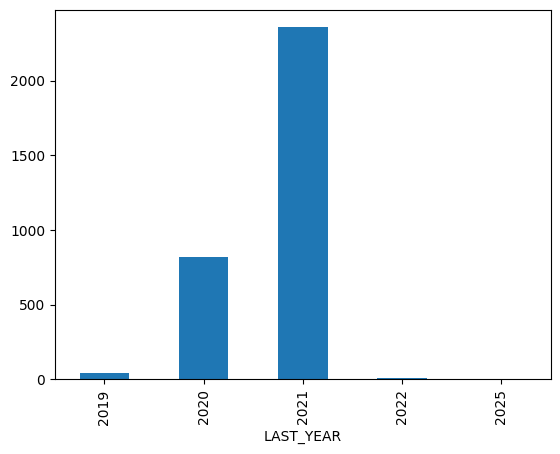

In [110]:
date_df['LAST_YEAR'] = date_df['PURCHASE_DT_MAX'].dt.year
date_df['LAST_YEAR'].value_counts().sort_index().plot(kind='bar')

Quite a lot of agent has a final selling date at 2021, meaning we cannot approach a very time sensitive approach.

PROD_CAT
Cat 1    10232935.06
Cat 2     5610835.00
Cat 3    24963325.87
Name: ANP_RIDER, dtype: float64

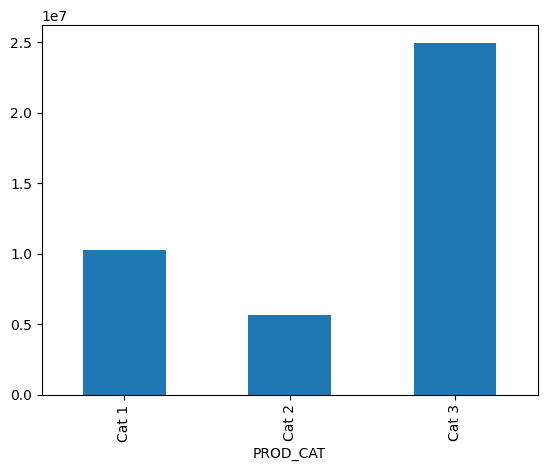

In [29]:
# Question 1
# What is the total ANP by categories?
df.groupby(['PROD_CAT'])['ANP_RIDER'].sum().plot(kind='bar')
df.groupby(['PROD_CAT'])['ANP_RIDER'].sum() 

In [41]:
# Question 3
#Number of agents who sold at least 5 Vitality attached policy.
agent_vit_group = df.groupby(['AGT_CD']).agg({'VIT_MBR_IND' : 'count'})
agent_vit_group[agent_vit_group['VIT_MBR_IND'] >= 5]

,VIT_MBR_IND
AGT_CD,
1,286
2,9
3,107
4,699
5,216
...,...
4792,5
4793,19
4794,6


In [45]:
#Question 4
#Number of policies with at least 3 riders attached.
# Filter only Rider Policy
df_rider = df[df['COVERAGE_TYPE_IND'] == 'R']
df_rider_group = df_rider.groupby(['POLICY_NO']).agg({'RIDER_CD' : 'count'})
df_rider_group[df_rider_group['RIDER_CD'] >= 3]

,RIDER_CD
POLICY_NO,
1,10
3,3
8,3
9,6
11,3
...,...
555571,3
556808,4
565910,3


## Data Transformation

In [ ]:
#Possible Feature for agent persona (agent behaviour)

## Overall
#1 . Number of basic policies sold per agent
#2 . Median/Average number of riders per basic policy


## Tendency of Portfolio
#3 . Ratio of LA/S_BASE
#4 . Ratio of LAT/S_BASE
#5 . Ratio of POLA/S_BASE

## Tendency of Main Need
#6 . Ratio Medical/MAIN_NEED
#7 . Ratio Life/MAIN_NEED
#8 . Ratio Disability/MAIN_NEED
#9 . Ratio Savers/MAIN_NEED
#10 . Ratio Payor_Waiver/MAIN_NEED
#11 . Ratio Critical_Illness/MAIN_NEED
#12 . Ratio Accident/MAIN_NEED
#13. Ratio Income/MAIN_NEED
#14 . Ratio Other_Medical/MAIN_NEED
#15 . Ratio Endowment/MAIN_NEED

#Time Sensitive Features
#16 . Median/Average number of policies sold per month 
#17 . Median/Average number of policies sold per year
#18 . Last Month/Last Year of purchase ## Not Using since we are looking at the agent persona throughout the years
#19 . Duration of First Purchase to Last Purchase (Served Duration as Agent)

In [ ]:
#Number of basic policies sold per agent
agent_group_basic = df.groupby(['AGT_CD']).agg({
'POLICY_NO': pd.Series.nunique})
agent_group_basic .rename(columns = {'POLICY_NO':'n_basic_policy'})

,n_basic_policy
AGT_CD,
1,56
2,5
3,45
4,146
5,61
...,...
4806,1
4807,1
4808,1


In [124]:
#Median/Average number of riders per basic policy
riders_per_policy = df[df['COVERAGE_TYPE_IND'] == 'R'].groupby(['AGT_CD','POLICY_NO']).agg({
'COVERAGE_TYPE_IND':'count'})
riders_per_policy.rename(columns={'COVERAGE_TYPE_IND': 'RIDER_COUNT'}, inplace=True)
avg_riders_per_agent = riders_per_policy.groupby('AGT_CD')['RIDER_COUNT'].mean().reset_index()
avg_riders_per_agent.rename(columns={'RIDER_COUNT': 'AVG_RIDERS_PER_POLICY'}, inplace=True)
avg_riders_per_agent

,AGT_CD,AVG_RIDERS_PER_POLICY
0,1,4.339623
1,2,1.000000
2,3,1.512195
3,4,3.787671
4,5,3.039216
...,...,...
3102,4794,5.000000
3103,4796,2.000000
3104,4801,1.500000
3105,4804,1.000000


Average number of riders per basic policy: 4.0288033203676745
